# KBA Challenge 2019
### starter code

## Step 1: Make features

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
%matplotlib inline

from xgboost import XGBRegressor
from xgboost import plot_importance

import time
import sys
import gc
import pickle
import platform

### Load Data

In [2]:
train = pd.read_csv('train.csv', encoding='cp949')
test  = pd.read_csv('test.csv', encoding='cp949')

### Feature Engineering

#### Transactions to monthly sales

*유의사항) Test Data에 있는 책 중에 1014개는 Train Data에는 없음.*

In [3]:
len(list(set(test.item_id) - set(test.item_id).intersection(set(train.item_id)))), len(test)

(1014, 13481)

월별 도서별 판매량 형식으로 데이터 변환

In [4]:
df = train.groupby(['month','item_id'])['count'].agg([('item_cnt_month', 'sum')]).reset_index()

target value(월별 도서 판매량)를 최대 20으로 조정

In [5]:
df['item_cnt_month'] = df['item_cnt_month'].clip(0,20)

In [6]:
df

,month,item_id,item_cnt_month
0,1,100004,1
1,1,100015,1
2,1,100018,1
3,1,100020,6
4,1,100077,2
...,...,...,...
224321,11,203051,2
224322,11,203052,1
224323,11,203054,3
224324,11,203059,1


#### Add a book category feature

In [7]:
df

,month,item_id,item_cnt_month
0,1,100004,1
1,1,100015,1
2,1,100018,1
3,1,100020,6
4,1,100077,2
...,...,...,...
224321,11,203051,2
224322,11,203052,1
224323,11,203054,3
224324,11,203059,1


In [8]:
df = pd.merge(df, 
              train.drop_duplicates(subset='item_id').loc[:,['item_id', 'category']], 
              on='item_id', how='left')

In [9]:
df

,month,item_id,item_cnt_month,category
0,1,100004,1,전집
1,1,100015,1,잡지
2,1,100018,1,중고등학습서
3,1,100020,6,잡지
4,1,100077,2,유아
...,...,...,...,...
224321,11,203051,2,자기계발
224322,11,203052,1,가정 살림
224323,11,203054,3,어린이
224324,11,203059,1,IT 모바일


#### Append test set

학습 데이터와 같은 feature를 만들기 위해 병합

In [10]:
test

,item_id,category
0,100000,잡지
1,100011,전집
2,100048,잡지
3,100058,유아
4,100068,잡지
...,...,...
13476,203058,중고등학습서
13477,203061,IT 모바일
13478,203065,국어 외국어 사전
13479,203068,수험서 자격증


In [11]:
test['month'] = 12  

In [12]:
df = pd.concat([df, test], ignore_index=True, sort=False).fillna(0)

In [13]:
df

,month,item_id,item_cnt_month,category
0,1,100004,1.0,전집
1,1,100015,1.0,잡지
2,1,100018,1.0,중고등학습서
3,1,100020,6.0,잡지
4,1,100077,2.0,유아
...,...,...,...,...
237802,12,203058,0.0,중고등학습서
237803,12,203061,0.0,IT 모바일
237804,12,203065,0.0,국어 외국어 사전
237805,12,203068,0.0,수험서 자격증


#### Add lag features

시차변수(1개월, 2개월, 3개월, 4개월 전 판매량) 생성

In [14]:
def lag_feature(df, lags, col):
    tmp = df[['month','item_id',col]]
    for i in lags:
        shifted = tmp.copy()
        shifted.columns = ['month','item_id', col+f'_lag_{i}']
        shifted['month'] += i
        df = pd.merge(df, shifted, on=['month','item_id'], how='left')
    return df

In [15]:
df = lag_feature(df, [1], 'item_cnt_month')

In [16]:
df

,month,item_id,item_cnt_month,category,item_cnt_month_lag_1
0,1,100004,1.0,전집,NaN
1,1,100015,1.0,잡지,NaN
2,1,100018,1.0,중고등학습서,NaN
3,1,100020,6.0,잡지,NaN
4,1,100077,2.0,유아,NaN
...,...,...,...,...,...
237802,12,203058,0.0,중고등학습서,NaN
237803,12,203061,0.0,IT 모바일,NaN
237804,12,203065,0.0,국어 외국어 사전,NaN
237805,12,203068,0.0,수험서 자격증,NaN


월 평균 판매량

In [17]:
group = df.groupby(['month'])['item_cnt_month'].agg([('month_avg_item_cnt', 'mean')]).reset_index()
df = pd.merge(df, group, on=['month'], how='left')

In [18]:
df = lag_feature(df, [1], 'month_avg_item_cnt')
df.drop(['month_avg_item_cnt'], axis=1, inplace=True)

In [19]:
df

,month,item_id,item_cnt_month,category,item_cnt_month_lag_1,month_avg_item_cnt_lag_1
0,1,100004,1.0,전집,NaN,NaN
1,1,100015,1.0,잡지,NaN,NaN
2,1,100018,1.0,중고등학습서,NaN,NaN
3,1,100020,6.0,잡지,NaN,NaN
4,1,100077,2.0,유아,NaN,NaN
...,...,...,...,...,...,...
237802,12,203058,0.0,중고등학습서,NaN,NaN
237803,12,203061,0.0,IT 모바일,NaN,NaN
237804,12,203065,0.0,국어 외국어 사전,NaN,NaN
237805,12,203068,0.0,수험서 자격증,NaN,NaN


도서 분야별 월평균 판매량

In [20]:
group = df.groupby(['month', 'category'])['item_cnt_month'].agg([('month_cat_avg_item_cnt', 'mean')]).reset_index()
df = pd.merge(df, group, on=['month', 'category'], how='left')
df = lag_feature(df, [1], 'month_cat_avg_item_cnt')
df.drop(['month_cat_avg_item_cnt'], axis=1, inplace=True)

In [21]:
book_info = pd.read_csv('book_info_all.csv', encoding='cp949')
book_info
df = pd.merge(df, book_info, on=['item_id','category'], how='left')

In [22]:
df

,month,item_id,item_cnt_month,category,item_cnt_month_lag_1,month_avg_item_cnt_lag_1,month_cat_avg_item_cnt_lag_1,title,author,publisher,pub_date
0,1,100004,1.0,전집,NaN,NaN,NaN,개구쟁이 특공대 최신판 (전13권),유키노유미코외,꼬마대통령(전집),20140101.0
1,1,100015,1.0,잡지,NaN,NaN,NaN,여성동아 B형 (여성월간) : 12월 [2013],동아일보사편집부 편,동아일보사,20131021.0
2,1,100018,1.0,중고등학습서,NaN,NaN,NaN,베리타스알파 고입·대입을 위한 고품격 교육 신문 (175호),편집부 저,소년한국일보,20140115.0
3,1,100020,6.0,잡지,NaN,NaN,NaN,Gentleman KOREA 젠틀맨 코리아 + 레몬아이 겨울호 : 2월 [2014],중앙M&B 편집부,중앙m&b,20121001.0
4,1,100077,2.0,유아,NaN,NaN,NaN,돌잡이 수학 세트,편집부,천재교육,20111001.0
...,...,...,...,...,...,...,...,...,...,...,...
237802,12,203058,0.0,중고등학습서,NaN,NaN,NaN,핵심3개년 수능기출 모의고사 모음집 고1 수학 (2015년),편집부,수능교육평가원,20141106.0
237803,12,203061,0.0,IT 모바일,NaN,NaN,NaN,최신! ICT 정보통신기술 종합백서 3,<정승혁> 저,WARMING(워밍),20141110.0
237804,12,203065,0.0,국어 외국어 사전,NaN,NaN,NaN,NEW 줄리정 불법 아이엘츠,<줄리정> 저,Sunny Sunday,20141121.0
237805,12,203068,0.0,수험서 자격증,NaN,NaN,NaN,독해의 신이 되는 절대독해법,<안남철> 저,Beyond,20141117.0


In [23]:
pv = pd.pivot_table(df, index = 'publisher', columns = 'month', values = 'item_cnt_month',aggfunc=np.sum, fill_value=0).reset_index()
pv.columns.name = 'index'
pv['11month_pub_cnt'] = pv[1]+pv[2]+pv[3]+pv[4]+pv[5]+pv[6]+pv[7]+pv[8]+pv[9]+pv[10]+pv[11] ;pv
pv

index,publisher,1,2,3,4,5,6,7,8,9,10,11,12,11month_pub_cnt
0,(도서출판) 바른기록,0,0,0,1,0,0,0,0,0,0,0,0,1
1,(사)녹색습지교육원,0,0,0,0,0,0,0,0,1,0,0,0,1
2,(사)한국자동차경주협회,0,0,0,0,0,0,0,0,1,1,0,0,2
3,(재)대화문화아카데미,0,1,0,0,0,1,1,2,0,1,1,0,7
4,(재)한국육상진흥회,0,0,0,1,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5407,히어나우시스템,0,0,0,0,0,0,0,0,0,1,0,0,1
5408,힐링앤북,0,0,2,0,1,0,1,0,0,0,1,0,5
5409,힐링타오(타오월드),0,0,1,0,0,0,0,0,0,0,1,0,2
5410,힐미디어,1,0,0,0,0,0,0,0,0,0,0,0,1


In [24]:
group = df.groupby(['publisher','item_id']).count().reset_index()
group

,publisher,item_id,month,item_cnt_month,category,item_cnt_month_lag_1,month_avg_item_cnt_lag_1,month_cat_avg_item_cnt_lag_1,title,author,pub_date
0,(도서출판) 바른기록,202340,1,1,1,0,0,0,1,1,1
1,(사)녹색습지교육원,190233,1,1,1,0,0,0,1,1,1
2,(사)한국자동차경주협회,189163,2,2,2,1,1,1,2,2,2
3,(재)대화문화아카데미,172025,6,6,6,3,3,3,6,6,6
4,(재)한국육상진흥회,172435,1,1,1,0,0,0,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...
99092,힐링앤북,202186,2,2,2,0,0,0,2,2,2
99093,힐링타오(타오월드),172192,2,2,2,0,0,0,2,2,2
99094,힐미디어,195537,1,1,1,0,0,0,1,1,1
99095,힐미디어,195538,1,1,1,0,0,0,1,1,1


In [25]:
group = group.iloc[:,:3]
group.rename(columns={'month':'count_per_pub'}, inplace=True)

In [26]:
group2 = pd.DataFrame(group.groupby('publisher')['item_id'].nunique()).reset_index()

In [27]:
gr = pd.merge(pv, group2, on=['publisher'], how='right')

In [28]:
gr

,publisher,1,2,3,4,5,6,7,8,9,10,11,12,11month_pub_cnt,item_id
0,(도서출판) 바른기록,0,0,0,1,0,0,0,0,0,0,0,0,1,1
1,(사)녹색습지교육원,0,0,0,0,0,0,0,0,1,0,0,0,1,1
2,(사)한국자동차경주협회,0,0,0,0,0,0,0,0,1,1,0,0,2,1
3,(재)대화문화아카데미,0,1,0,0,0,1,1,2,0,1,1,0,7,1
4,(재)한국육상진흥회,0,0,0,1,0,0,0,0,0,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5407,히어나우시스템,0,0,0,0,0,0,0,0,0,1,0,0,1,1
5408,힐링앤북,0,0,2,0,1,0,1,0,0,0,1,0,5,2
5409,힐링타오(타오월드),0,0,1,0,0,0,0,0,0,0,1,0,2,1
5410,힐미디어,1,0,0,0,0,0,0,0,0,0,0,0,1,2


In [29]:
gr['pub_month_avg_cnt']=gr['11month_pub_cnt']/gr['item_id']
gr

,publisher,1,2,3,4,5,6,7,8,9,10,11,12,11month_pub_cnt,item_id,pub_month_avg_cnt
0,(도서출판) 바른기록,0,0,0,1,0,0,0,0,0,0,0,0,1,1,1.0
1,(사)녹색습지교육원,0,0,0,0,0,0,0,0,1,0,0,0,1,1,1.0
2,(사)한국자동차경주협회,0,0,0,0,0,0,0,0,1,1,0,0,2,1,2.0
3,(재)대화문화아카데미,0,1,0,0,0,1,1,2,0,1,1,0,7,1,7.0
4,(재)한국육상진흥회,0,0,0,1,0,0,0,0,0,0,0,0,1,1,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5407,히어나우시스템,0,0,0,0,0,0,0,0,0,1,0,0,1,1,1.0
5408,힐링앤북,0,0,2,0,1,0,1,0,0,0,1,0,5,2,2.5
5409,힐링타오(타오월드),0,0,1,0,0,0,0,0,0,0,1,0,2,1,2.0
5410,힐미디어,1,0,0,0,0,0,0,0,0,0,0,0,1,2,0.5


In [30]:
gr = gr.iloc[:,[0,-1]]

In [31]:
df = pd.merge(df, gr, on=['publisher'], how='left')

#### Final data preparation
Lag feature를 적용할 수 없는 1월부터 4월 데이터 제거

In [32]:
df = df[df.month > 4]

결측값 0으로 치환

In [33]:
df.isnull().sum()

month                               0
item_id                             0
item_cnt_month                      0
category                            0
item_cnt_month_lag_1            97159
month_avg_item_cnt_lag_1        97159
month_cat_avg_item_cnt_lag_1    97159
title                               8
author                            113
publisher                           8
pub_date                           91
pub_month_avg_cnt                   8
dtype: int64

In [34]:
def fill_na(df):
    df = df.replace([np.inf, -np.inf], np.nan)
    for col in df.columns:
        if ('_lag_' in col) & (df[col].isnull().any()):
            if ('item_cnt' in col):
                df[col].fillna(0, inplace=True)         
    return df

df = fill_na(df)
df['pub_month_avg_cnt'].fillna(0,inplace=True)
# df['author_month_avg_cnt'].fillna(0, inplace=True)

pickle 형태로 분석에 사용할 최종 데이터 저장 및 시각화

In [35]:
df.to_pickle('data.pkl')

In [36]:
# df_sampled = df.sample(n = 500).iloc[:,[2,4,5,6,7]]
# sns.pairplot(df_sampled, diag_kind = 'kde')
# plt.show()

<br/>

## Step 2: Build models

### Split Data

In [37]:
df.isnull().sum()

month                             0
item_id                           0
item_cnt_month                    0
category                          0
item_cnt_month_lag_1              0
month_avg_item_cnt_lag_1          0
month_cat_avg_item_cnt_lag_1      0
title                             8
author                          113
publisher                         8
pub_date                         91
pub_month_avg_cnt                 0
dtype: int64

In [38]:
df = pd.read_pickle('data.pkl')

In [39]:
df = df.drop(columns=['item_id','author','publisher','pub_date','title'])
df = pd.get_dummies(df)

아래와 같이 데이터를 분할:
- Test Data: 12월 데이터
- Validation Data: 11월 데이터
- Train Data: 5~10월 데이터

In [40]:
X_train = df[df.month < 11].drop(['item_cnt_month'], axis=1)
y_train = df[df.month < 11]['item_cnt_month']
X_valid = df[df.month == 11].drop(['item_cnt_month'], axis=1)
y_valid = df[df.month == 11]['item_cnt_month']
X_test = df[df.month == 12].drop(['item_cnt_month'], axis=1)

In [41]:
# X_train = X_train.iloc[:,1:]
# X_valid = X_valid.iloc[:,1:]
# X_test = X_test.iloc[:,1:]

### Train & Evaluate the Model

Ramdomforest를 사용하여 모델링

In [42]:
from sklearn.ensemble import RandomForestRegressor
import sklearn.metrics as metrics
import math

In [43]:
ts = time.time()

model = RandomForestRegressor(n_estimators=200, max_depth=6
                              ,random_state=12345)

model.fit(X_train, y_train)
y_hat = model.predict(X_valid)

mse = metrics.mean_squared_error(y_valid , y_hat)
print ("RMSE:               ", math.sqrt(mse))


time.time() - ts

RMSE:                2.3723534676845515


57.67595624923706

XGBOOST를사용하여 모델링

In [63]:
ts = time.time()


model = XGBRegressor(n_estimators=200, max_depth=5, min_child_weight=350,eta=0.001, colsample_bytree=0.1,seed=12345)

model.fit(
    X_train, 
    y_train, 
    eval_metric='rmse', 
    eval_set=[(X_train, y_train), (X_valid, y_valid)], 
    verbose=True,
    early_stopping_rounds = 10)

time.time() - ts

[19:58:25] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:2.91572	validation_1-rmse:3.25645
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:2.85556	validation_1-rmse:3.19437
[2]	validation_0-rmse:2.80102	validation_1-rmse:3.14477
[3]	validation_0-rmse:2.76007	validation_1-rmse:3.10071
[4]	validation_0-rmse:2.65024	validation_1-rmse:2.99785
[5]	validation_0-rmse:2.61839	validation_1-rmse:2.96754
[6]	validation_0-rmse:2.56598	validation_1-rmse:2.91313
[7]	validation_0-rmse:2.53511	validation_1-rmse:2.88126
[8]	validation_0-rmse:2.51921	validation_1-rmse:2.86269
[9]	validation_0-rmse:2.50599	validation_1-rmse:2.84698
[10]	validation_0-rmse:2.49493	validation_1-rmse:2.83329
[11]	validation_0-rmse:2.48615	validation_1-rmse:2.82191
[12

[139]	validation_0-rmse:2.1378	validation_1-rmse:2.4583
[140]	validation_0-rmse:2.13645	validation_1-rmse:2.45694
[141]	validation_0-rmse:2.13645	validation_1-rmse:2.45693
[142]	validation_0-rmse:2.12531	validation_1-rmse:2.44623
[143]	validation_0-rmse:2.12532	validation_1-rmse:2.44622
[144]	validation_0-rmse:2.12531	validation_1-rmse:2.44621
[145]	validation_0-rmse:2.12531	validation_1-rmse:2.44623
[146]	validation_0-rmse:2.12529	validation_1-rmse:2.44631
[147]	validation_0-rmse:2.12528	validation_1-rmse:2.44634
[148]	validation_0-rmse:2.1252	validation_1-rmse:2.44605
[149]	validation_0-rmse:2.12519	validation_1-rmse:2.44599
[150]	validation_0-rmse:2.12519	validation_1-rmse:2.44601
[151]	validation_0-rmse:2.12518	validation_1-rmse:2.446
[152]	validation_0-rmse:2.12517	validation_1-rmse:2.44599
[153]	validation_0-rmse:2.12436	validation_1-rmse:2.44587
[154]	validation_0-rmse:2.12426	validation_1-rmse:2.44558
[155]	validation_0-rmse:2.12407	validation_1-rmse:2.44544
[156]	validation_0-

59.77375340461731

In [45]:
# 2.47 / 4.39  (n_estimators=100, max_depth=2, eta=0.001, min_child_weight=350,colsample_bytree=0.1,seed=12345)

XGB 학습곡선 시각화

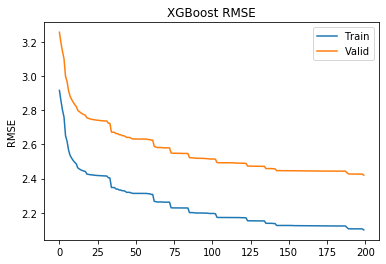

In [64]:
results = model.evals_result()
epochs = len(results['validation_1']['rmse'])
x_axis = range(0, epochs)
# plot rmse
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['rmse'], label='Train')
ax.plot(x_axis, results['validation_1']['rmse'], label='Valid')
ax.legend()
plt.ylabel('RMSE')
plt.title('XGBoost RMSE')
plt.show()

변수 중요도 시각화

In [47]:
# def plot_features(booster, figsize):    
#     fig, ax = plt.subplots(1,1,figsize=figsize)
#     return plot_importance(booster=booster, ax=ax)

# plot_features(model, (10,14))

### stacking

In [48]:
# from sklearn.linear_model import LinearRegression

In [49]:
# clfs=[]
# LR = LinearRegression() ; clfs.append(LR)
# XGB=XGBRegressor(n_estimators=100, max_depth=1, eta=0.001, min_child_weight=350, colsample_bytree=0.1,seed=12345); clfs.append(XGB)
# RF= RandomForestRegressor(n_estimators=100, max_depth=6,
#                               n_jobs=-1,
#                               random_state=12345); clfs.append(RF)

In [50]:
# from vecstack import stacking
# from sklearn.ensemble import GradientBoostingRegressor
# GBM=GradientBoostingRegressor(random_state=12345)
# models = clfs
# S_train, S_test = stacking(models,                     # list of models
#                            X_train, y_train, X_test,   # data
#                            regression=True,           # classification task (if you need  - 선형모델 필요하면 True
#                                                        #     regression - set to True)
#                            needs_proba=False,          # predict class labels (if you need 
#                                                        #     probabilities - set to True) 
#                            metric=mse,      # metric: callable # 성능 측정 기준
#                            n_folds=3,                  # number of folds
#                            stratified=True,            # stratified split for folds
#                            shuffle=False,               # shuffle the data
#                            random_state=12345             # ensure reproducibility
#                            )                  # print all info
# meta_model = GBM.fit(S_train, y_train)

## 뉴럴넷

In [51]:
# %run import_modules.py  
# %matplotlib inline

# # For DNN modeling
# import tensorflow as tf

# # Tensorflow warning off
# if tf.__version__[0] < '2':
#     os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
#     tf.logging.set_verbosity(tf.logging.ERROR)

# from tensorflow import random
# import keras
# from keras import backend as K
# from keras.layers import * #Input, Dense
# from keras.models import * #Model
# from keras.optimizers import *
# from keras.initializers import *
# from keras.regularizers import *
# from keras.utils.np_utils import *
# from keras.utils.vis_utils import * #model_to_dot

In [52]:
# from keras import backend as K
# def root_mean_squared_error(y_true, y_pred):
#         return K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1)) 

In [53]:
# model.compile(loss=root_mean_squared_error, 
#               optimizer='Adam', 
#               metrics=[keras.metrics.mse])

# model.summary()
# callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)]

In [54]:
# hist = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), batch_size=32, epochs=20, callbacks=callbacks, 
#                  shuffle=False, verbose=2) 

In [55]:
# plt.plot(hist.history["loss"], label="train loss")
# plt.plot(hist.history["val_loss"], label="validation loss")
# plt.legend()
# plt.xlabel('epoch')
# plt.title("Loss")
# plt.show()

### Make Submissions

In [62]:
y_test = model.predict(X_test).clip(0, 20)

submission = pd.DataFrame({
    "item_id": test.item_id, 
    "item_cnt_month": y_test
})

t = pd.Timestamp.now()
fname = f"submission_{t.month:02}{t.day:02}_{t.hour:02}{t.minute:02}.csv"
submission.to_csv(fname, index=False)


In [57]:
# #y_pred = model.predict(X_valid).clip(0, 20)
# # y_test = model.predict(X_test).clip(0, 20)
# y_test = meta_model.predict(S_test).clip(0, 20)
# submission = pd.DataFrame({
#     "item_id": test.item_id, 
#     "item_cnt_month": y_test
# })

# t = pd.Timestamp.now()
# fname = f"submission_{t.month:02}{t.day:02}_{t.hour:02}{t.minute:02}.csv"
# submission.to_csv(fname, index=False)

# # save predictions for an ensemble
# #pickle.dump(y_pred, open('xgb_train.pickle', 'wb'))
# #pickle.dump(y_test, open('xgb_test.pickle', 'wb'))

# End